# Fully connected neural network (FCNN)

Forecast Nino 3.4 index using the principal components of SST

In [107]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [115]:
# Hyperparameters
hp = {
    'lead': 3,    # Target lead (months)
    'batch_size': 16,
    'period': {
        'train': (1940, 1992),
        'val': (1993, 2007),
        'test': (2008, 2022),
    }
}

In [116]:
# Read Nino indices
f = 'data/era5_nino.csv'
nino = pd.read_csv(f, index_col=0, parse_dates=True)[['nino34']]

# Shift time index
nino_shift = nino.set_index(nino.index - pd.DateOffset(months=hp['lead']))

# Read SST PCs
f = 'data/era5_monthly_sst_pc.nc'
pc = xr.open_dataarray(f)
pc = pc.sel(mode=slice(1, 3))

# Normalize PCs
pc /= pc.std(dim='time')

print(f'{nino.shape = :}')
print(f'{pc.shape = :}')

nino.shape = (1008, 1)
pc.shape = (3, 1008)


## Dataset & Dataloader

In [117]:
class SSTDataset(Dataset):
    def __init__(self, pc, nino):
        self.pc = pc
        self.nino = nino

    def __len__(self):
        return len(self.nino)

    def __getitem__(self, idx):
        x = self.pc[idx].float()
        y = self.nino[idx].float()
        return x, y 

In [118]:
datasets = {}
dataloaders = {}
for key, period in hp['period'].items():
    syy, eyy = period
    print(key, period)

    # Select period
    pc_sel = pc.sel(time=slice(f'{syy}-01-01', f'{eyy}-12-31')).T
    nino_sel = nino_shift.loc[f'{syy}-01-01':f'{eyy}-12-31', 'nino34']

    # To tensor
    pc_sel = torch.from_numpy(pc_sel.data)
    nino_sel = torch.from_numpy(nino_sel.values)

    # Datasets
    datasets[key] = SSTDataset(pc_sel, nino_sel)
    dataloaders[key] = DataLoader(datasets[key],
                                  batch_size=hp['batch_size'],
                                  shuffle=True)

train (1940, 1992)
val (1993, 2007)
test (2008, 2022)


# Model

In [119]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.fcnn = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        # x = self.flatten(x)
        return self.fcnn(x)

In [121]:
model = NeuralNetwork().to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params: {total_params:,}')

NeuralNetwork(
  (fcnn): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Total params: 353


# Train

In [122]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [123]:
epochs = 100

history = []
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch, (x, y) in enumerate(dataloaders['train']):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)[:, 0]
        loss = loss_fn(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    train_loss /= len(dataloaders['train'])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloaders['val']):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:, 0]
            loss = loss_fn(y_pred, y)

        val_loss += loss.item()
    val_loss /= len(dataloaders['val'])

    # Store loss
    history.append({
        'train_loss': train_loss,
        'val_loss': val_loss,
    })

history = pd.DataFrame(history)

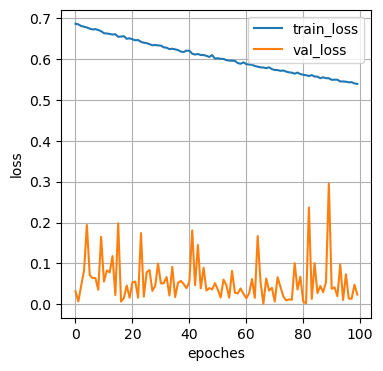

In [124]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(history, label=history.columns)
ax.legend()
ax.set(
    xlabel='epoches',
    ylabel='loss',
)
ax.grid()